# European Football Analysis

**Table of Contents**<a id='toc0_'></a>    
- 1. [Introduction     ](#toc1_)    
- 2. [Notebook Preparation     ](#toc2_)    
- 3. [Data Availability     ](#toc3_)    
  - 3.1. [Summary on Data Availability   ](#toc3_1_)    
- 4. [Goal Scoring     ](#toc4_)    
  - 4.1. [Summary on Goal Scoring  ](#toc4_1_)    
- 5. [Home Advantage     ](#toc5_)    
  - 5.1. [Summary on Home Advantage  ](#toc5_1_)    
- 6. [Formation Influence ](#toc6_)    
  - 6.1. [Summary on Formation Influence ](#toc6_1_)    
- 7. [Match Result Prediction ](#toc7_)    
  - 7.1. [Match Outcome Prediction ](#toc7_1_)    
    - 7.1.1. [Summary on Match Outcome Prediction ](#toc7_1_1_)    
  - 7.2. [Home Team Goal Prediction ](#toc7_2_)    
    - 7.2.1. [Summary on Home Goal Prediction ](#toc7_2_1_)    
  - 7.3. [Away Team Goal Prediction ](#toc7_3_)    
    - 7.3.1. [Summary on Away Goal Prediction ](#toc7_3_1_)    
- 8. [Recommendations ](#toc8_)    
- 9. [Suggestions for Improvements ](#toc9_)    
- 10. [Data for Looker Studio Dashboard](#toc10_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Note that the links in the above table of contents do not work on GitHub or Google Colab. In Google Colab, please use its embedded table of contents.

## 1. <a id='toc1_'></a>Introduction      [&#8593;](#toc0_)

Association football, more commonly known as football or soccer, is the world's most popular sport. However, in some parts of the world, it is still not understood well. American sports betting company identified betting on European football as an potential new business opportunity. As the company doesn't know a lot about football, I am asked to analyze European football dataset and see if I can provide anything that could give a competitive advantage in the attempt to start strong in the new endeavour. 

The **aim** of this work is to analyze European football dataset and provide insights possibly useful for the sports betting company.

The work **objectives** are as follows:
* Explore the dataset to identify scoring tendencies among leagues, teams and players;
* Formulate and test hypothesis to investigate home advantage phenomena;
* Investigate formation influence on match result;
* Build a model to predict match outcome in top European leagues;
* Build a model to predict goals scored in each match in top European Leagues. 

The **resource** for this work is [European Soccer Database](https://www.kaggle.com/datasets/hugomathien/soccer) containing information on more than 25 000 matches. The dataset also contains players and teams' attributes from *EA Sports FIFA* video game, betting odds from multiple providers and team line-ups before each match.

This analysis is accompanied by two appendices. The appendix `Dataset Schema` presents dataset content. The appendix `Feature Engineering` presents feature creation and initial selection.

## 2. <a id='toc2_'></a>Notebook Preparation      [&#8593;](#toc0_)

Import libraries for data analysis and visualization. Set parameters for display.

In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
from scipy import stats 
import statsmodels.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Patch
from helper_functions import preprocessing, custom_model

# Modeling
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import mutual_info_classif, f_regression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error, precision_score
from sklearn.base import clone

# Display
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (8, 4.5),
    "figure.autolayout": True,
    "axes.titlesize": "large",  
    "patch.edgecolor": "w",
    "patch.linewidth": 0.5,
}
sns.set_theme(style="whitegrid", rc=custom_params)
pd.set_option("display.precision", 3,"display.max_colwidth", None)
facecolor = sns.color_palette()[0]
emphasiscolor = sns.color_palette()[3]

%matplotlib inline
%config InlineBackend.figure_format = 'png'

Download the dataset from [Kaggle](https://www.kaggle.com/datasets/hugomathien/soccer), if it is not already in the `data` folder, and load it. For the method provided below to work, [Kaggle API](https://github.com/Kaggle/kaggle-api) needs to be configured on the system:

In [2]:
dataset_file = "./data/database.sqlite"

if not os.path.exists(dataset_file):
    !kaggle datasets download --unzip hugomathien/soccer -p data
else:
    print("Data already downloaded")

Data already downloaded


Establish connection to the dataset. Tables available in the dataset are listed below. The columns available for each table are listed in the appendix notebook `appendix_dataset_schema.ipynb`. The appendix also deals with availability of data within table columns.

In [3]:
conn = sqlite3.connect(dataset_file)
display(
    pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name", conn
    )
)

,name
0,Country
1,League
2,Match
3,Player
4,Player_Attributes
5,Team
6,Team_Attributes
7,sqlite_sequence


## 3. <a id='toc3_'></a>Data Availability      [&#8593;](#toc0_)

There are data on 11 countries and their top football leagues provided in the dataset.

In [4]:
query = """
        SELECT c.name Country, l.name League 
          FROM League l
         INNER JOIN Country c ON l.country_id = c.id  
        """
pd.read_sql(query, conn)

,Country,League
0,Belgium,Belgium Jupiler League
1,England,England Premier League
2,France,France Ligue 1
3,Germany,Germany 1. Bundesliga
4,Italy,Italy Serie A
5,Netherlands,Netherlands Eredivisie
6,Poland,Poland Ekstraklasa
7,Portugal,Portugal Liga ZON Sagres
8,Scotland,Scotland Premier League
9,Spain,Spain LIGA BBVA


The dataset covers seasons 2008/2009 through 2015/2016.

In [5]:
query = """
        SELECT DISTINCT season
          FROM Match
        """
pd.read_sql(query, conn)

,season
0,2008/2009
1,2009/2010
2,2010/2011
3,2011/2012
4,2012/2013
5,2013/2014
6,2014/2015
7,2015/2016


Different leagues have different number of leagues competing. Twenty teams compete in England, France, Italy, and Spain leagues, 18 - in Germany, the Netherlands, and Portugal (increased from 16 in 2014/2015 Season), 16 - in Belgium (decreased from 18 in 2009/2010) and Poland, 12 - in Scotland, and 10 - in Switzerland. Records for only 15 teams are available for Belgium 2008/2019 season as one team was relegated due to financial problems. Even more records are missing for Belgium 2013/2014 season due to unknown reasons.

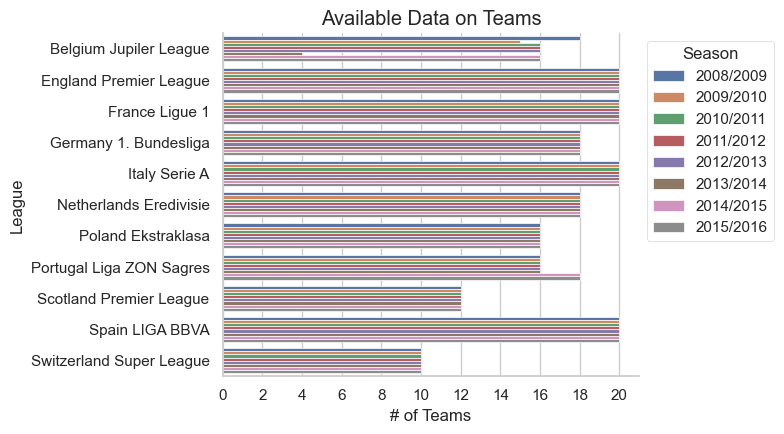

In [6]:
query = """
        SELECT l.name League, m.season Season, 
               COUNT(DISTINCT m.home_team_api_id) Teams,
               COUNT(*) Matches,     
               SUM(m.home_team_goal + m.away_team_goal) Goals
          FROM Match m
         INNER JOIN League l ON m.league_id = l.id
         GROUP BY League, Season    
        """
league_season_df = pd.read_sql(query, conn)
ax = sns.barplot(data=league_season_df, y="League", x="Teams", hue="Season")
ax.set(title="Available Data on Teams", xlabel="# of Teams")
ax.set_xticks(range(0, 21, 2))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Available data on played matches reflect the difference in the number of teams within the leagues. Still most of the records for Belgium 2013/2014 season are missing. However, some records are also missing for Italy and Switzerland 2011/2012 season.

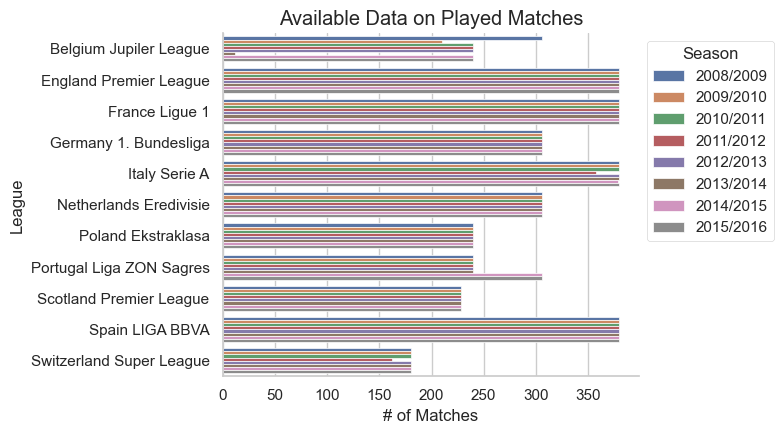

In [7]:
ax = sns.barplot(data=league_season_df, y="League", x="Matches", hue="Season")
ax.set(title="Available Data on Played Matches", xlabel="# of Matches")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### 3.1. <a id='toc3_1_'></a>Summary on Data Availability    [&#8593;](#toc0_)

Initial data availability analysis shows that:
1. The provided *European Soccer Database* contains match data from 11 countries top football leagues from seasons 2008/2009 to 2015/2016.
2. There are different number of teams playing in each league.
3. Belgium league lacks most of the match information for 2013/2014 season, while Italy and Switzerland leagues lacks some information for 2011/2012 season.

## 4. <a id='toc4_'></a>Goal Scoring      [&#8593;](#toc0_)

Considering the average number of goals scored per match over different seasons, leagues of Poland and France show the lowest numbers, while those of Switzerland and the Netherlands - the highest. This could be taken into consideration when predicting the number of goals scored per match.

In [8]:
league_season_df["Goals per Match"] = (
    league_season_df["Goals"] / league_season_df["Matches"]
)
goals = (
    league_season_df.groupby("Season")["Goals per Match"]
    .agg(["mean", "min", "max", "idxmin", "idxmax"])
    .reset_index()
)
goals["Min League"] = league_season_df.loc[goals["idxmin"], "League"].values
goals["Max League"] = league_season_df.loc[goals["idxmax"], "League"].values
goals.drop(["idxmin", "idxmax"], axis=1, inplace=True)
goals.rename(
    columns={
        "mean": "Mean Goals per Match",
        "min": "Min Goals per Match",
        "max": "Max Goals per Match",
    },
    inplace=True,
)
goals

,Season,Mean Goals per Match,Min Goals per Match,Max Goals per Match,Min League,Max League
0,2008/2009,2.607,2.183,3.000,Poland Ekstraklasa,Switzerland Super League
1,2009/2010,2.687,2.217,3.328,Poland Ekstraklasa,Switzerland Super League
2,2010/2011,2.689,2.342,3.225,France Ligue 1,Netherlands Eredivisie
3,2011/2012,2.706,2.196,3.258,Poland Ekstraklasa,Netherlands Eredivisie
4,2012/2013,2.767,2.492,3.150,Poland Ekstraklasa,Netherlands Eredivisie
5,2013/2014,2.746,2.371,3.196,Portugal Liga ZON Sagres,Netherlands Eredivisie
6,2014/2015,2.688,2.492,3.078,France Ligue 1,Netherlands Eredivisie
7,2015/2016,2.782,2.526,3.144,France Ligue 1,Switzerland Super League


To get the list of top scorers, additional information about the goals is needed. However, this information is lacking for almost all seasons for the leagues of Belgium, the Netherlands, Poland, Portugal, Scotland, and Switzerland. Also, all or considerable part of goal information is missing for seasons 2008/2009 to 2011/2012 for the league of France; hence, the analysis of top scorers will be only performed for the seasons 2012/2013 to 2015/2016 for the leagues of England, France, Germany, Italy, and Spain.

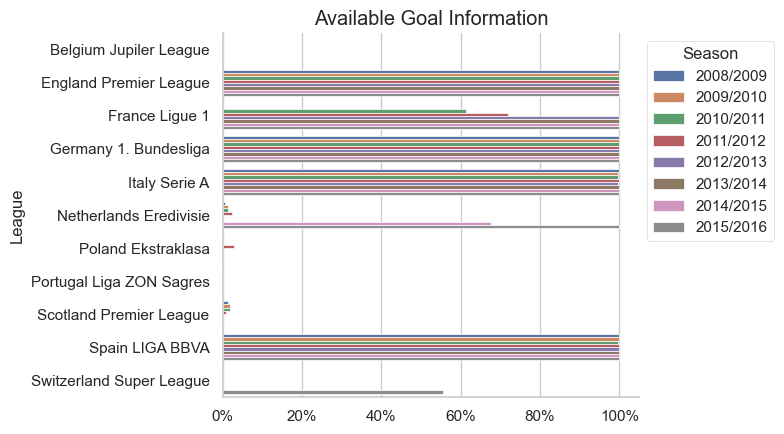

In [9]:
query = """
        SELECT l.name League, m.season Season, count(*) Total_Matches,
               count(m.goal) Available_Goal_Info
          FROM Match m
         INNER JOIN League l ON m.league_id = l.id 
         GROUP BY League, Season
        """
goals_nans = pd.read_sql(query, conn)
goals_nans["Percentage"] = (
    goals_nans["Available_Goal_Info"] / goals_nans["Total_Matches"] * 100
)
ax = sns.barplot(data=goals_nans, x="Percentage", y="League", hue="Season")
ax.set(title="Available Goal Information", xlabel="")
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=100, decimals=0))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [10]:
def func_scorer(row):
    """To extract team and player goal info from xml."""
    try:
        df = pd.read_xml(row["goal_xml"])
        df = df[df["comment"].isin(["n", "p"])]  # take only goal and penalty
        y = list(zip(df["team"], df["player1"]))
        return y
    except:
        return None


query = """
        SELECT m.match_api_id match_id, m.date Date, m.season Season, 
               l.name League, m.goal goal_xml
          FROM Match m
         INNER JOIN League l ON m.league_id = l.id
         INNER JOIN Country c ON m.country_id = c.id
         WHERE (m.goal IS NOT NULL) 
              AND ((m.home_team_goal + m.away_team_goal) > 0)
              AND (m.season IN ("2012/2013", "2013/2014", "2014/2015", "2015/2016"))  
              AND (c.name IN ("England", "France", "Germany", "Italy", "Spain"))            
        """
goals_df = pd.read_sql(query, conn)

goals_df["team_player_ids"] = goals_df.apply(func_scorer, axis=1)
goals_df.drop(columns="goal_xml", inplace=True)
goals_df = goals_df.explode("team_player_ids")
goals_df = goals_df[~goals_df["team_player_ids"].isna()]
goals_df["team_id"], goals_df["player_id"] = zip(*goals_df["team_player_ids"])
goals_df.drop(columns="team_player_ids", inplace=True)
goals_df = goals_df[~goals_df["player_id"].isna()]
goals_df = goals_df.astype({"team_id": int, "player_id": int})

query = """
        SELECT team_api_id team_id, team_long_name Team
          FROM Team
        """
team_id_name = pd.read_sql(query, conn)
query = """
        SELECT player_api_id player_id, player_name Player
          FROM Player
        """
player_id_name = pd.read_sql(query, conn)
goals_df = goals_df.merge(team_id_name, on="team_id").merge(
    player_id_name, on="player_id"
)
goals_df.drop(columns=["team_id", "player_id"], inplace=True)

Over the included seasons, top 3 scorers scored most of the goals in the Spain league. Considering Germany having less matches during the season, the total number of goals scored by the top 3 scorers in this league is comparable to those of the other analyzed leagues except the one of Spain.

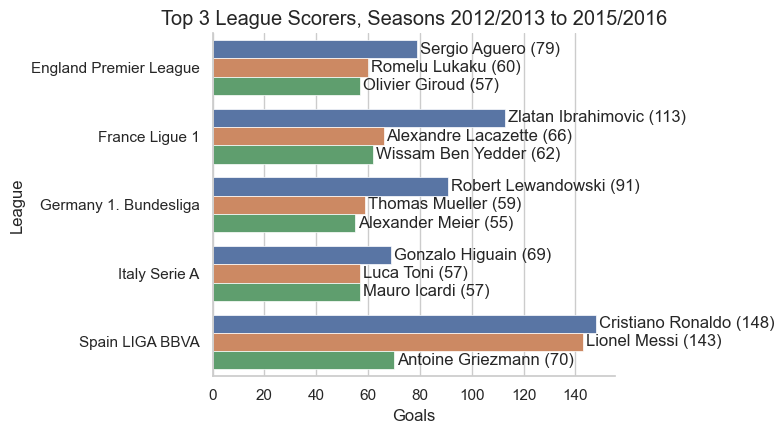

In [11]:
scorers_league_top3 = (
    goals_df.groupby(by=["League", "Player"])["Player"]
    .count()
    .reset_index(name="Goals")
)
scorers_league_top3["Place"] = (
    scorers_league_top3.groupby("League")["Goals"]
    .rank(method="first", ascending=False)
    .astype(int)
)
scorers_league_top3 = scorers_league_top3[scorers_league_top3["Place"] <= 3]
ax = sns.barplot(data=scorers_league_top3, x="Goals", y="League", hue="Place")
for idx, cont in enumerate(ax.containers):
    ax.bar_label(
        cont,
        labels=scorers_league_top3[
            scorers_league_top3["Place"] == idx + 1
        ].apply(lambda row: f"{row.Player} ({row.Goals})", axis=1),
        padding=2,
    )
ax.set(title="Top 3 League Scorers, Seasons 2012/2013 to 2015/2016")
ax.get_legend().remove()

During seasons 2012/2013 to 2015/2016, Lionel Messi, Christiano Ronaldo, Zlatan Ibrahimovic, and Luis Suarez were among top 3 season scorers at least twice.

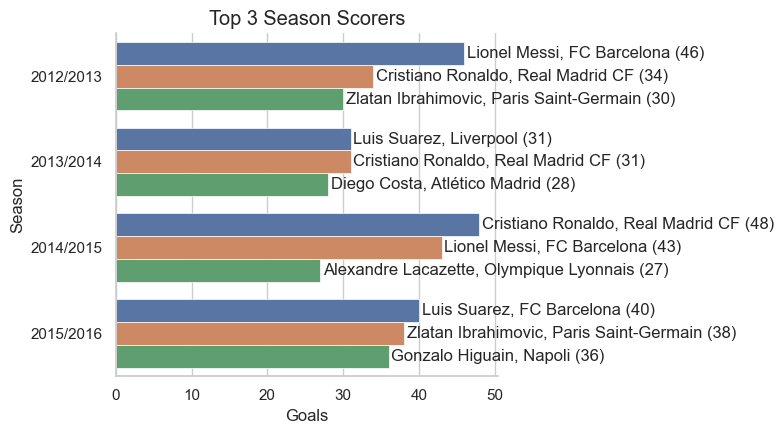

In [12]:
scorers_season_top3 = (
    goals_df.groupby(by=["Season", "League", "Team", "Player"])["Player"]
    .count()
    .reset_index(name="Goals")
)
scorers_season_top3["Place"] = (
    scorers_season_top3.groupby("Season")["Goals"]
    .rank(method="first", ascending=False)
    .astype(int)
)
scorers_season_top3 = scorers_season_top3[scorers_season_top3["Place"] <= 3]
ax = sns.barplot(data=scorers_season_top3, x="Goals", y="Season", hue="Place")
for idx, cont in enumerate(ax.containers):
    ax.bar_label(
        cont,
        labels=scorers_season_top3[
            scorers_season_top3["Place"] == idx + 1
        ].apply(lambda row: f"{row.Player}, {row.Team} ({row.Goals})", axis=1),
        padding=2,
    )
ax.set(title="Top 3 Season Scorers")
ax.get_legend().remove()

### 4.1. <a id='toc4_1_'></a>Summary on Goal Scoring   [&#8593;](#toc0_)

Analysis of goal scoring tendencies showed that:
1. Matches played in Poland and France result in the lowest numbers of goals scored per match on average, while those in Switzerland and the Netherlands - the highest.
2. Reliable goal information could be obtained only for 5 leagues from England, France, Germany, Italy, and Spain during seasons 2012/2013 to 2015/2016.
2. In season 2012/2013 to 2015/2016, top scorers scored most of the goals in the Spain League.
3. Lionel Messi, Christiano Ronaldo, Zlatan Ibrahimovic, and Luis Suarez were among top 3 season scorers at least twice during those seasons.

## 5. <a id='toc5_'></a>Home Advantage      [&#8593;](#toc0_)

To investigate if there is such a thing as home advantage, the differences of scored goals by home and away teams are calculated. The **null hypothesis** is raised that the population mean of the differences of goals scored between home and away teams playing the match is zero or less. The **alternative hypothesis** is that the population mean of the differences is greater than zero. **Population** here are European football teams playing in the analyzed leagues. **Parameter of interest** is the population mean of the differences of goals scored between home and away teams (home goals - away goals). The significance level of $\alpha=0.05$ is used to calculate the confidence interval and perform a one-sample t-test.

In [13]:
query = """
        SELECT m.match_api_id, m.season Season, l.name League,
               m.home_team_api_id home_id, m.away_team_api_id away_id, 
               m.home_team_goal home_goal, m.away_team_goal away_goal
          FROM Match m
         INNER JOIN League l ON m.league_id = l.id
        """
home_away_df = pd.read_sql(query, conn)
home_away_df["Home Goals - Away Goals"] = (
    home_away_df["home_goal"] - home_away_df["away_goal"]
)

The distribution of difference between home an away goals is bell-shaped. Most of the matches ended in a tie, but the mean goal difference is greater than zero indicating that there were more matches won by home team than away team. The goal difference ranges from -9 to 10, but 50% of matches ended up in a difference of -1, 0, and 1, actually.

count    25979.000
mean         0.384
std          1.782
min         -9.000
25%         -1.000
50%          0.000
75%          1.000
max         10.000
Name: Home Goals - Away Goals, dtype: float64

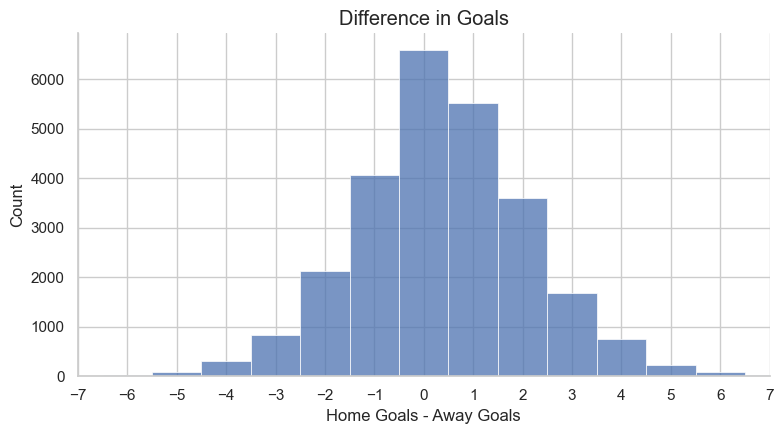

In [14]:
ax = sns.histplot(
    data=home_away_df,
    x="Home Goals - Away Goals",
    binwidth=1,
    discrete=True,
)
ax.set(title="Difference in Goals", xticks=range(-7, 8), xlim=(-7, 7))
display(home_away_df["Home Goals - Away Goals"].describe())
plt.show()

In [15]:
data = home_away_df["Home Goals - Away Goals"]
ttest_results = stats.ttest_1samp(
    a=data,
    popmean=0,
    alternative="greater",
)
mu = np.mean(data)
ci = stats.t.interval(0.95, len(data) - 1, mu, stats.sem(data))
ci = tuple([round(x, 3) for x in ci])
print(
    f"t-test results are: \n{ttest_results}, \nso the null hypothesis is"
    " rejected in favour of the alternative. \nMean difference of goals with"
    f" 95% confidence interval is {mu:.3f} {ci}."
)

t-test results are: 
TtestResult(statistic=34.693433428329804, pvalue=3.7880129771512274e-258, df=25978), 
so the null hypothesis is rejected in favour of the alternative. 
Mean difference of goals with 95% confidence interval is 0.384 (0.362, 0.405).


With 95% confidence, we reject the null hypothesis of zero mean difference between home and away teams in favor of the alternative hypothesis that home teams score more goals than away teams, on average.

It can be seen that mean difference in goals changes throughout the years. One thing to explore is to check if this home advantage is significantly larger in the first four years compared to the last four years. For this, it is assumed that matches played in these two season groups are independent. 

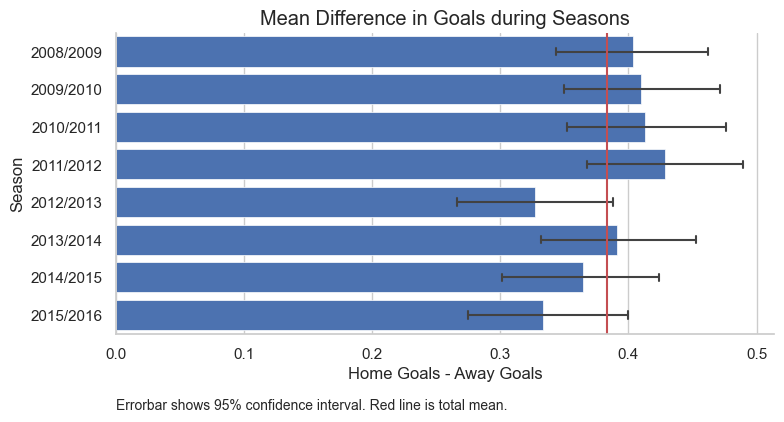

In [16]:
ax = sns.barplot(
    data=home_away_df,
    x="Home Goals - Away Goals",
    y="Season",
    seed=1,
    capsize=0.2,
    errwidth=1.5,
    facecolor=facecolor,
)
ax.axvline(x=mu, color=emphasiscolor)
info_text = "Errorbar shows 95% confidence interval. Red line is total mean."
ax.text(0, 9.5, info_text, fontsize=10)
ax.set(title="Mean Difference in Goals during Seasons")
plt.show()

In [17]:
data1 = home_away_df.loc[
    home_away_df["Season"].isin(
        ["2008/2009", "2009/2010", "2010/2011", "2011/2012"]
    ),
    "Home Goals - Away Goals",
]
data2 = home_away_df.loc[
    home_away_df["Season"].isin(
        ["2012/2013", "2013/2014", "2014/2015", "2015/2016"]
    ),
    "Home Goals - Away Goals",
]
mu1 = np.mean(data1)
mu2 = np.mean(data2)
cm = sms.stats.CompareMeans(
    sms.stats.DescrStatsW(data1), sms.stats.DescrStatsW(data2)
)
ci = cm.tconfint_diff(usevar="unequal", alpha=0.05)
ci = tuple([round(x, 3) for x in ci])
test_stat, pval, _ = cm.ttest_ind(usevar="unequal", alternative="larger")
print(
    f"The mean goal difference in 2008-2012 seasons was {mu1:.3f}, and in"
    f" 2012-2016 seasons it was {mu2:.3f}. \nThe difference in those means"
    f" with 95% confidence interval was {mu1-mu2:.3f} {ci}. \nThe hypothesis"
    " of equal means is rejected in favour of the alternative with p-value ="
    f" {pval:.3f}."
)

The mean goal difference in 2008-2012 seasons was 0.414, and in 2012-2016 seasons it was 0.353. 
The difference in those means with 95% confidence interval was 0.060 (0.017, 0.104). 
The hypothesis of equal means is rejected in favour of the alternative with p-value = 0.003.


With 95% confidence, we reject the null hypothesis of zero difference between mean goal differences in 2008-2012 and 2012-2016 in favor of the alternative hypothesis that this mean goal difference is larger in the first four seasons compared to the latter four. 

Home advantage effect is not uniform across the leagues. It is stronger in the Netherlands and Spain, but weaker in Portugal and Scotland. 95% confidence intervals for mean difference in goals in these leagues do not contain total mean, and thus, with 95% confidence, we say that mean difference in goals in these leagues is different from the total mean.

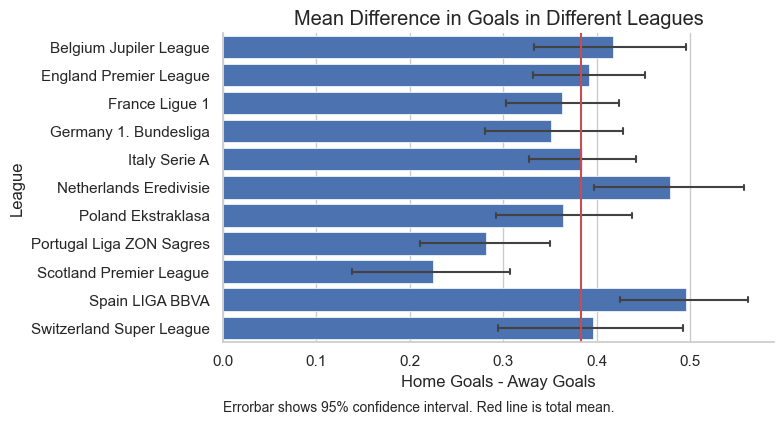

In [18]:
ax = sns.barplot(
    data=home_away_df,
    x="Home Goals - Away Goals",
    y="League",
    seed=1,
    capsize=0.2,
    errwidth=1.5,
    facecolor=facecolor,
)
ax.axvline(x=mu, color=emphasiscolor)
ax.text(0, 13, info_text, fontsize=10)
ax.set(title="Mean Difference in Goals in Different Leagues")
plt.show()

### 5.1. <a id='toc5_1_'></a>Summary on Home Advantage   [&#8593;](#toc0_)

Hypothesis testing about home advantage phenomena provides these insights with 95% confidence:
1. Home teams on average score more goals than away teams.  
2. In seasons 2012-2016, home advantage effect was smaller compared to 2008-2012 seasons.
3. Home advantage effect is greater than average in the Netherlands and Spain.
3. Home advantage effect is smaller than average in Portugal and Scotland.

## 6. <a id='toc6_'></a>Formation Influence  [&#8593;](#toc0_)

3-6-1 and 5-4-1 formations are less common, and thus, they are removed from the comparison regarding formation influence. Also, 5-3-2 formation is not so common. Most common formations are 4-3-3, 4-4-2, and 4-5-1. Note that formations are only of the form x-x-x, and thus, formations of the form x-x-x-x falls under this umbrella. For example, formation 4-2-3-1 is distinguished as 4-5-1.

In [19]:
match_data = pd.read_pickle("match.pkl")
formation = match_data[["Result", "formation_home", "formation_away"]].copy()
formation = preprocessing.drop_rows_nans(formation)
formation.rename(
    columns={
        "formation_home": "Home Formation",
        "formation_away": "Away Formation",
    },
    inplace=True,
)
print("Count of different combinations of home and away formations:")
formation.pivot_table(
    values="Result",
    index="Home Formation",
    columns="Away Formation",
    aggfunc="count",
    margins=True,
).style.background_gradient(cmap="Blues", axis=None, vmax=1000)

Dropped rows due to NaNs: 7.08%.
Count of different combinations of home and away formations:


Away Formation,3-4-3,3-5-2,3-6-1,4-3-3,4-4-2,4-5-1,5-3-2,5-4-1,All
Home Formation,,,,,,,,,
3-4-3,71,83,0,94,159,165,14,8,594
3-5-2,64,185,0,172,217,149,23,11,821
3-6-1,0,1,0,2,1,3,1,0,8
4-3-3,100,166,2,2348,1138,1590,55,27,5426
4-4-2,166,246,8,1218,4801,2275,38,36,8788
4-5-1,186,156,0,1462,1937,4400,52,51,8244
5-3-2,15,20,1,47,50,41,11,4,189
5-4-1,2,2,2,17,19,27,1,0,70
All,604,859,13,5360,8322,8650,195,137,24140


5-3-2 is very defensive formation. It is selected not so often and home teams using this formation tend to win less often than away teams using other formations. However, it seems to boost the number of draws if played by the away team against home team using 3-4-3 or 3-5-2 formations. When the away team used 4-3-3, 4-4-2, or 4-5-1  formation, the most effective strategy for home team was to use 4-3-3 formation. 4-4-2 used by the home team was effective against 3-4-3 and 3-5-2. However, when the home team was aiming for the win or draw, 3-4-3 was the most effective strategy against 3-5-2 played by the away team. 

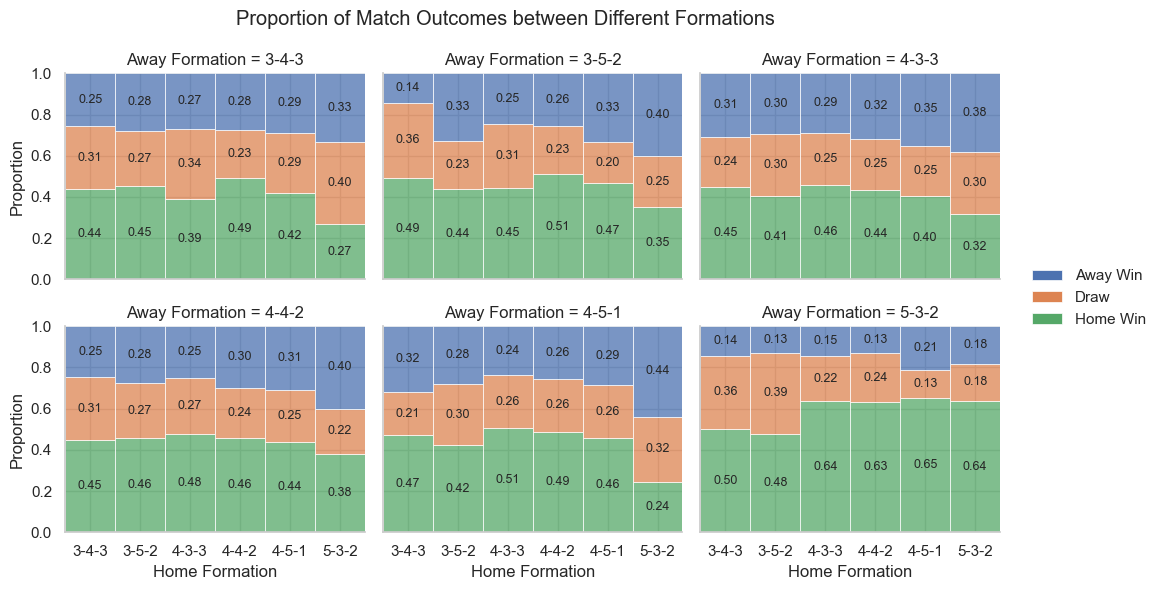

In [20]:
def annotate_bars(**kwargs):
    ax = plt.gca()
    for p in ax.patches:
        w, h = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if h > 0:
            ax.annotate(
                f"{h:.2f}",
                (x + w / 2.0, y + h / 2.0),
                ha="center",
                va="center",
                fontsize=9,
            )


formation.drop(
    formation[
        formation["Home Formation"].isin(["3-6-1", "5-4-1"])
        | formation["Away Formation"].isin(["3-6-1", "5-4-1"])
    ].index,
    inplace=True,
)
formation["Home Formation"] = formation[
    "Home Formation"
].cat.remove_unused_categories()
formation["Away Formation"] = formation[
    "Away Formation"
].cat.remove_unused_categories()

result_order = ["Away Win", "Draw", "Home Win"]
g = sns.FacetGrid(formation, col="Away Formation", col_wrap=3)
g.map_dataframe(
    sns.histplot,
    x="Home Formation",
    hue="Result",
    hue_order=result_order,
    stat="proportion",
    multiple="fill",
    legend=True,
)
g.map(annotate_bars)
handles = [Patch(fc=sns.color_palette()[i]) for i in range(len(result_order))]
g.add_legend(legend_data=dict(zip(result_order, handles)))
sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5))
g.figure.suptitle("Proportion of Match Outcomes between Different Formations")
plt.show()

### 6.1. <a id='toc6_1_'></a>Summary on Formation Influence  [&#8593;](#toc0_)

The short analysis of formation influence shows that:
1. 5-3-2 formation increases the number of draws if played by the away team against home team using 3-4-3 or 3-5-2 formations.
2. 4-3-3 formation is the most effective formation to use for home team if away team is using 4-3-3, 4-4-2, or 4-5-1 formation.
3. 3-4-3 formation is the most effective strategy for the home team aiming for the win or draw, against 3-5-2 played by the away team. 

## 7. <a id='toc7_'></a>Match Result Prediction  [&#8593;](#toc0_)

Feature engineering is described in the appendix notebook `appendix_feature_engineering.ipynb`. Initially, features were selected using data from leagues of England, France, Germany, Italy, and Spain from seasons 2010/2011 through 2014/2015 because these leagues and seasons had team attributes available. The same approach is continued forward; hence, match result predictions are only applicable for the same five leagues and the first two seasons are omitted when building the models. All features are created from historical data and no input from the current match is used except for the team lineup. This means betting odds from other companies are also ignored.

In [21]:
data = match_data.copy()
data.drop(
    data[data["Season"].isin(["2008/2009", "2009/2010"])].index, inplace=True
)
data["Season"] = data["Season"].cat.remove_unused_categories()
data.drop(
    data[
        ~data["League"].str.contains(
            "England|France|Germany|Italy|Spain", regex=True
        )
    ].index,
    inplace=True,
)
data["League"] = data["League"].cat.remove_unused_categories()
data.drop(
    columns=["date", "formation_away", "formation_home", "League"],
    inplace=True,
)

The last season is holdout for testing and the rest are used for training.

In [22]:
data_test = data[data["Season"].isin(["2015/2016"])].copy()
data_train = data[~data["Season"].isin(["2015/2016"])].copy()
X_train = data_train.drop(
    columns=["Result", "Home Goals", "Away Goals", "Season"]
)
X_test = data_test.drop(
    columns=["Result", "Home Goals", "Away Goals", "Season"]
)

The boxplots of initially selected features show that there might be outliers in the dataset. However, the values also do not seem as some kind of faulty data because the ranges are reasonable.

In [23]:
X_train.describe(percentiles=[0.5]).T

,count,mean,std,min,50%,max
overall_rating_home,9107.0,74.533,3.866,63.500,74.000,86.636
overall_rating_away,9107.0,74.449,3.901,63.000,73.909,87.273
overall_rating_diff,9107.0,0.084,5.240,-16.364,0.091,18.909
season_GD_home,9107.0,-0.202,14.502,-53.000,-1.000,89.000
season_GD_away,9107.0,0.221,14.488,-52.000,-1.000,88.000
season_scored_avg_home,9107.0,1.290,0.583,0.000,1.207,6.000
season_scored_avg_away,9107.0,1.310,0.593,0.000,1.222,7.000
win_prop_home,9065.0,0.466,0.182,0.000,0.448,1.000
win_prop_away,9065.0,0.281,0.160,0.000,0.257,1.000
loss_prop_home,9065.0,0.274,0.149,0.000,0.268,1.000


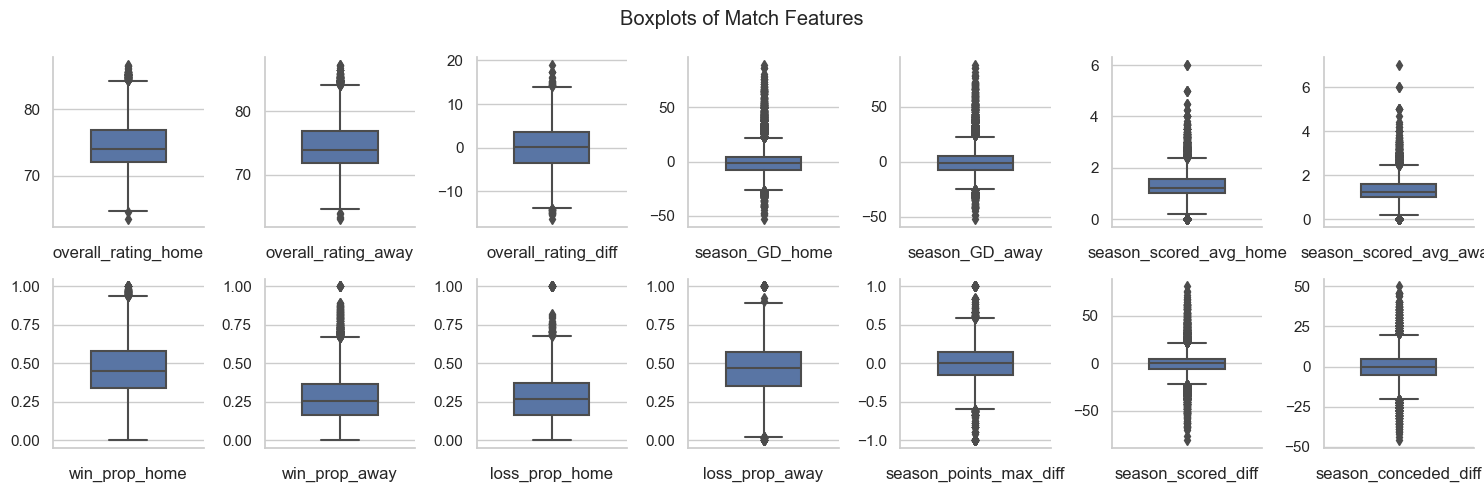

In [24]:
fig, axes = plt.subplots(2, 7, figsize=(15, 5))
axes = axes.flatten()
for idx, col in enumerate(X_train.columns):
    sns.boxplot(y=X_train[col], ax=axes[idx], width=0.5)
    axes[idx].set(xlabel=col, ylabel=None)
fig.suptitle("Boxplots of Match Features")
plt.show()

Since most of the features do not follow normal distribution, Spearman rank correlation coefficient is used to obtain correlation matrix.

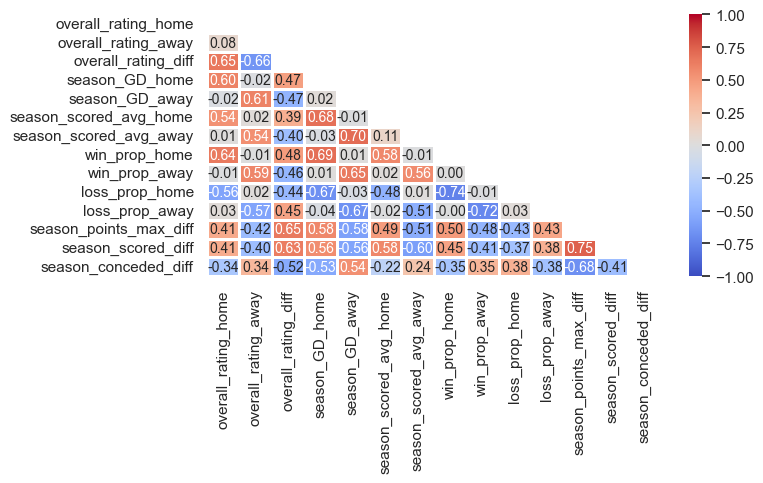

In [25]:
corr_matrix = X_train.corr("spearman")
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8, 5))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    annot_kws={"size": 10},
    cmap="coolwarm",
    fmt=".2f",
    center=0,
    linewidths=1,
    vmin=-1,
    vmax=1,
)
plt.grid(False)
plt.show()

Most of the features exhibit correlation between each other. These correlations should be kept in mind when building the models.

### 7.1. <a id='toc7_1_'></a>Match Outcome Prediction  [&#8593;](#toc0_)

Histograms below show that distinguishing between different match outcomes is a complicated classification tasks since none of the distributions of the initially selected features are easy to differentiate.

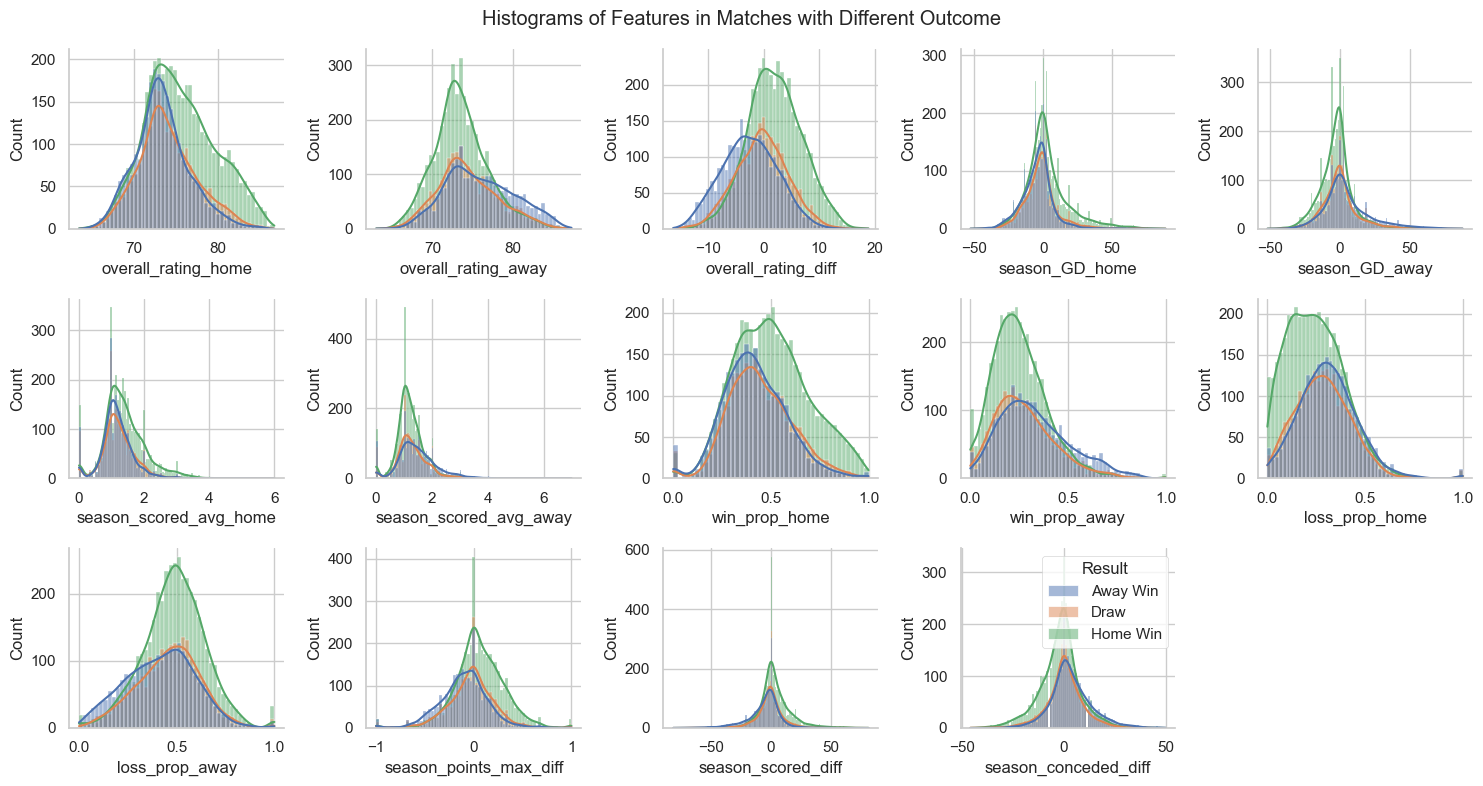

In [26]:
fig, axes = plt.subplots(3, 5, figsize=(15, 8))
axes = axes.flatten()
show_legend = False
for idx, col in enumerate(X_train.columns):
    if idx == 13:
        show_legend = True
    sns.histplot(
        data=data_train,
        x=col,
        hue="Result",
        kde=True,
        ax=axes[idx],
        legend=show_legend,
    )
axes[14].axis("off")
fig.suptitle("Histograms of Features in Matches with Different Outcome")
plt.show()

Barplot of match outcomes show that home team wins is more common than away team wins or draws, thus, the classes are imbalanced.

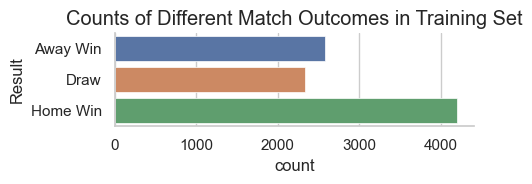

In [27]:
plt.figure(figsize=(5, 2))
sns.countplot(data=data_train, y="Result")
plt.title("Counts of Different Match Outcomes in Training Set")
plt.show()

Using mutual information, top ten features are selected to be used with match outcome prediction. Mutual information between two random variables measures the dependency between them. Missing values are imputed with medians of the features.

In [28]:
Y_train_win = (
    data_train["Result"]
    .replace({"Away Win": 0, "Draw": 1, "Home Win": 2})
    .astype(int)
)
Y_test_win = (
    data_test["Result"]
    .replace({"Away Win": 0, "Draw": 1, "Home Win": 2})
    .astype(int)
)
X_train_no_nans = X_train.fillna(X_train.median())
mi = mutual_info_classif(X_train_no_nans, Y_train_win, random_state=0)
features_win = (
    pd.Series(mi, index=X_train.columns).nlargest(n=10).index.to_list()
)
features_win

['overall_rating_diff',
 'season_scored_diff',
 'overall_rating_away',
 'season_points_max_diff',
 'overall_rating_home',
 'loss_prop_home',
 'season_GD_home',
 'win_prop_home',
 'season_conceded_diff',
 'win_prop_away']

To compare different sets of features, micro averaged precision is used. This score shows the proportion of correctly labeled outputs, so it is essentially the same as accuracy. Cross validation is performed using time series splitter which ensures that the model is trained on data collected earlier in time than the data used for validation. Logistic regression model is selected for this task. Missing values are imputed with medians and the features are standardized.

In [29]:
precision_scorer = make_scorer(
    precision_score, average="micro", greater_is_better=True
)

log_reg_clf = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    LogisticRegression(multi_class="multinomial", class_weight="balanced"),
)
print(
    "Mean (standard deviation) of micro-averaged precision for logistic"
    " regression model:"
)
for i in range(10):
    feat = features_win[: 10 - i]
    scores = cross_val_score(
        log_reg_clf,
        X_train[feat],
        Y_train_win,
        cv=TimeSeriesSplit(n_splits=5),
        scoring=precision_scorer,
    )
    print(
        f"{scores.mean().round(3)} ({scores.std().round(3)}) with features"
        f" {feat}"
    )

Mean (standard deviation) of micro-averaged precision for logistic regression model:
0.486 (0.024) with features ['overall_rating_diff', 'season_scored_diff', 'overall_rating_away', 'season_points_max_diff', 'overall_rating_home', 'loss_prop_home', 'season_GD_home', 'win_prop_home', 'season_conceded_diff', 'win_prop_away']
0.487 (0.024) with features ['overall_rating_diff', 'season_scored_diff', 'overall_rating_away', 'season_points_max_diff', 'overall_rating_home', 'loss_prop_home', 'season_GD_home', 'win_prop_home', 'season_conceded_diff']
0.486 (0.022) with features ['overall_rating_diff', 'season_scored_diff', 'overall_rating_away', 'season_points_max_diff', 'overall_rating_home', 'loss_prop_home', 'season_GD_home', 'win_prop_home']
0.485 (0.019) with features ['overall_rating_diff', 'season_scored_diff', 'overall_rating_away', 'season_points_max_diff', 'overall_rating_home', 'loss_prop_home', 'season_GD_home']
0.489 (0.014) with features ['overall_rating_diff', 'season_scored_diff

The best micro-averaged precision with cross-validation is 49.3% achieved using just two features defining difference in overall team rating and difference in scored goals during current season.

In [30]:
features_win_final = ["overall_rating_diff", "season_scored_diff"]
final_clf = clone(log_reg_clf)
final_clf.fit(X_train[features_win_final], Y_train_win)
custom_model.model_representation(
    final_clf, type="classif", labels=["Away Win", "Draw", "Home Win"]
)

IMPUTER


,overall_rating_diff,season_scored_diff
median,0.091,0.0


SCALER


,overall_rating_diff,season_scored_diff
Mean,0.084,-0.190
Scale,5.240,13.504


MODEL COEFFICIENTS


,overall_rating_diff,season_scored_diff,Intercept
Class,,,
Away Win,-0.398,-0.169,-0.077
Draw,-0.019,0.010,0.076
Home Win,0.417,0.159,0.001


The base model for match outcome prediction task is always predicting home team win. On the training set, this base model reaches micro-averaged precision of 46.1%. The developed model improves this metric up to 48.6%.

TRAINING SET:
Classification metrics: 
                   pre       rec       spe        f1       geo       iba       sup

   Away Win       0.44      0.58      0.71      0.50      0.64      0.41      2578
       Draw       0.30      0.23      0.82      0.26      0.43      0.17      2329
   Home Win       0.61      0.58      0.68      0.59      0.63      0.39      4200

avg / total       0.48      0.49      0.73      0.48      0.58      0.34      9107



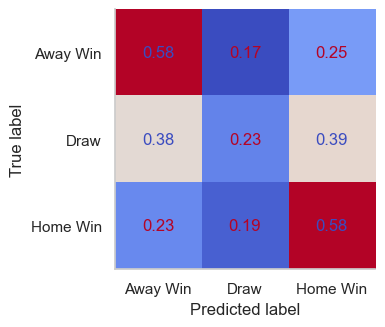

Micro-averaged precision of developed model 0.486.
Micro-averaged precision of base model 0.461.


In [31]:
Y_train_win_pred = final_clf.predict(X_train[features_win_final])
print("TRAINING SET:")
custom_model.print_classification_results(
    Y_train_win, Y_train_win_pred, labels=["Away Win", "Draw", "Home Win"]
)
print(
    "Micro-averaged precision of developed model"
    f" {round(precision_score(Y_train_win, Y_train_win_pred, average='micro'), 3)}."
)
print(
    "Micro-averaged precision of base model"
    f" {round(Y_train_win.value_counts()[2] / Y_train_win.shape[0], 3)}."
)

The base model reaches micro-averaged precision of 44.4% on the test set. The developed model shows micro-averaged precision of 48.2%. The model correctly recalls more than half of home and away team wins, but recalls draw less successfully.

TEST SET:
Classification metrics: 
                   pre       rec       spe        f1       geo       iba       sup

   Away Win       0.44      0.52      0.72      0.48      0.61      0.37       543
       Draw       0.33      0.26      0.81      0.29      0.46      0.20       473
   Home Win       0.59      0.58      0.68      0.59      0.63      0.39       810

avg / total       0.48      0.48      0.72      0.48      0.58      0.33      1826



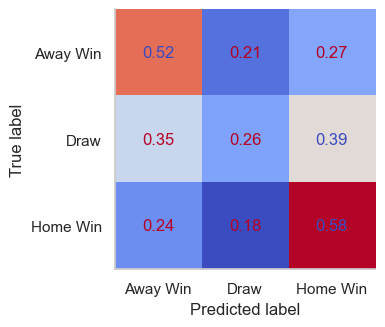

Micro-averaged precision of developed model 0.482.
Micro-averaged precision of base model 0.444.


In [32]:
Y_test_win_pred = final_clf.predict(X_test[features_win_final])
print("TEST SET:")
custom_model.print_classification_results(
    Y_test_win, Y_test_win_pred, labels=["Away Win", "Draw", "Home Win"]
)
print(
    "Micro-averaged precision of developed model"
    f" {round(precision_score(Y_test_win, Y_test_win_pred, average='micro'), 3)}."
)
print(
    "Micro-averaged precision of base model"
    f" {round(Y_test_win.value_counts()[2] / Y_test_win.shape[0], 3)}."
)

#### 7.1.1. <a id='toc7_1_1_'></a>Summary on Match Outcome Prediction  [&#8593;](#toc0_)

Building a model to predict football match outcomes provides these insights:
1. Of the analyzed features, the ones providing information on differences of average ratings of team players and goals scored in the season by the team are most useful.
2. However, using these features, the percentage of correctly predicted outcomes are increased only to 48.2% from 44.4% reached by the base model of always predicting home team win.
3. Match outcome prediction is a complicated task calling for more sophisticated features and possibly non-linear algorithms.

### 7.2. <a id='toc7_2_'></a>Home Team Goal Prediction  [&#8593;](#toc0_)

Scatterplots of initially selected features against home team goals shows already that there is no clear linear relationships between features and scored goals. Same feature values may be observed with low and high number of goals.

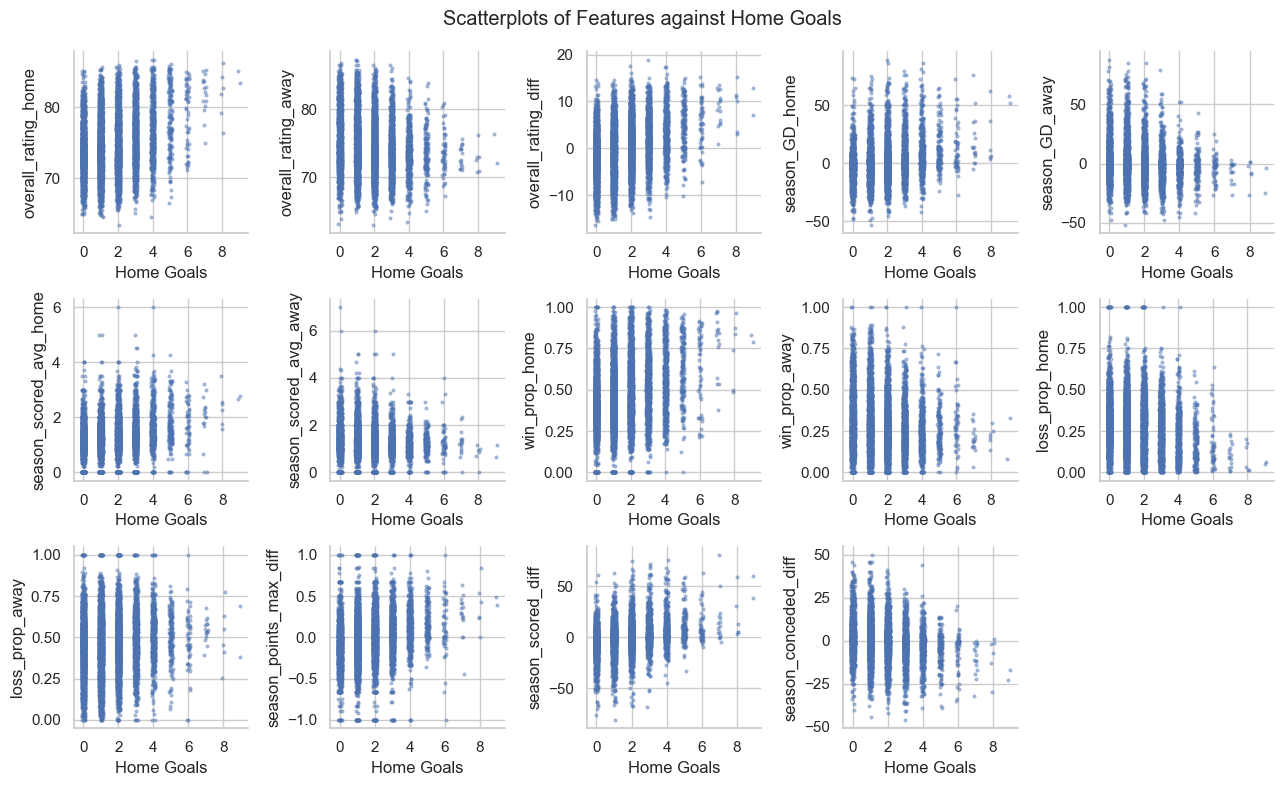

In [33]:
fig, axes = plt.subplots(3, 5, figsize=(13, 8))
axes = axes.flatten()
for idx, col in enumerate(X_train.columns):
    sns.regplot(
        data=data_train,
        x="Home Goals",
        y=col,
        ax=axes[idx],
        x_jitter=0.1,
        scatter_kws={"s": 4, "alpha": 0.4},
        fit_reg=False,
    )
    axes[idx].set_xticks(range(0, 10, 2))
axes[14].axis("off")
fig.suptitle("Scatterplots of Features against Home Goals")
plt.show()

Also, smaller number of goals, such as 0, 1, 2, or 3, are more common than higher number of goals.

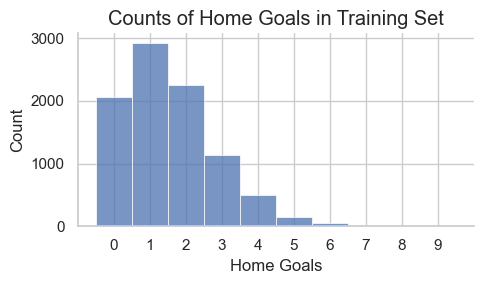

In [34]:
plt.figure(figsize=(5, 3))
ax = sns.histplot(data=data_train, x="Home Goals", discrete=True)
plt.xticks(range(10))
plt.title("Counts of Home Goals in Training Set")
plt.show()

Top ten features are selected to be used with home goal prediction based on linear regression tests returning F-statistic for the effect of a single regressor.

In [35]:
Y_train_home_goal = data_train["Home Goals"]
Y_test_home_goal = data_test["Home Goals"]
f, _ = f_regression(X_train_no_nans, Y_train_home_goal)
features_home_goal = (
    pd.Series(f, index=X_train.columns).nlargest(n=10).index.to_list()
)
features_home_goal

['overall_rating_diff',
 'overall_rating_home',
 'season_scored_diff',
 'season_points_max_diff',
 'season_GD_home',
 'win_prop_home',
 'season_scored_avg_home',
 'season_conceded_diff',
 'loss_prop_home',
 'overall_rating_away']

To compare different sets of features, root mean square error (RMSE) is used. Again, cross validation is performed using time series splitter. Linear regression model is selected for the task but the output is converted to discrete values to represent realistic prediction of whole goal numbers. 

In [49]:
def bayesian_ic(y_true: pd.Series, y_pred: np.ndarray, num_params: int) -> int:
    """Calculate Bayesian information criterion (BIC)."""
    mse = mean_squared_error(y_true, y_pred)
    n = len(y_true)
    bic = round(n * log(mse) + (num_params + 1) * log(n))
    return bic


from math import log
from sklearn.linear_model import PoissonRegressor

RMSE_scorer = make_scorer(
    mean_squared_error, greater_is_better=False, squared=False
)
poi_reg = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler(), PoissonRegressor()
)
print(
    "Mean (standard deviation) of RMSE and BIC for linear regression model for"
    " home goal prediction:"
)
for i in range(10):
    feat = features_home_goal[: 10 - i]
    scores = cross_val_score(
        poi_reg,
        X_train[feat],
        Y_train_home_goal,
        cv=TimeSeriesSplit(n_splits=5),
        scoring=RMSE_scorer,
    )
    poi_reg.fit(X_train[feat], Y_train_home_goal)
    y_predict = poi_reg.predict(X_train[feat])
    bic = bayesian_ic(Y_train_home_goal, y_predict, len(feat))
    print(
        f"{-scores.mean().round(3)} ({scores.std().round(3)}) and {bic} for"
        f" features {feat}"
    )

Mean (standard deviation) of RMSE and BIC for linear regression model for home goal prediction:
1.217 (0.021) and 3604 for features ['overall_rating_diff', 'overall_rating_home', 'season_scored_diff', 'season_points_max_diff', 'season_GD_home', 'win_prop_home', 'season_scored_avg_home', 'season_conceded_diff', 'loss_prop_home', 'overall_rating_away']


1.218 (0.021) and 3605 for features ['overall_rating_diff', 'overall_rating_home', 'season_scored_diff', 'season_points_max_diff', 'season_GD_home', 'win_prop_home', 'season_scored_avg_home', 'season_conceded_diff', 'loss_prop_home']
1.218 (0.021) and 3595 for features ['overall_rating_diff', 'overall_rating_home', 'season_scored_diff', 'season_points_max_diff', 'season_GD_home', 'win_prop_home', 'season_scored_avg_home', 'season_conceded_diff']
1.219 (0.021) and 3593 for features ['overall_rating_diff', 'overall_rating_home', 'season_scored_diff', 'season_points_max_diff', 'season_GD_home', 'win_prop_home', 'season_scored_avg_home']
1.219 (0.021) and 3591 for features ['overall_rating_diff', 'overall_rating_home', 'season_scored_diff', 'season_points_max_diff', 'season_GD_home', 'win_prop_home']
1.22 (0.021) and 3584 for features ['overall_rating_diff', 'overall_rating_home', 'season_scored_diff', 'season_points_max_diff', 'season_GD_home']
1.22 (0.021) and 3572 for features ['overall

In [50]:
features_home_goal_final = [
    "overall_rating_diff",
    "overall_rating_home",
    "season_scored_diff",
    "season_points_max_diff",
]
final_home_goal_reg = clone(poi_reg)
final_home_goal_reg.fit(X_train[features_home_goal_final], Y_train_home_goal)
custom_model.model_representation(final_home_goal_reg, type="regression")

IMPUTER


,overall_rating_diff,overall_rating_home,season_scored_diff,season_points_max_diff
median,0.091,74.0,0.0,0.0


SCALER


,overall_rating_diff,overall_rating_home,season_scored_diff,season_points_max_diff
Mean,0.084,74.533,-0.190,-0.009
Scale,5.240,3.866,13.504,0.260


MODEL COEFFICIENTS


,overall_rating_diff,overall_rating_home,season_scored_diff,season_points_max_diff,Intercept
0,0.097,0.074,0.057,0.046,0.411


RMSE = 1.254, R^2 = 0.065


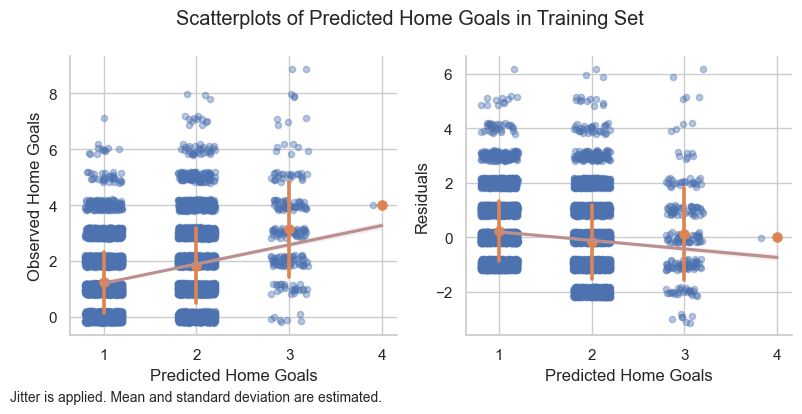

In [51]:
Y_train_home_goal_pred = discretize_and_above_zero(
    final_home_goal_reg.predict(X_train[features_home_goal_final])
)
fig = custom_model.print_regression_results(
    Y_train_home_goal, Y_train_home_goal_pred, y_name="Home Goals"
)
fig.suptitle("Scatterplots of Predicted Home Goals in Training Set")
info_text = "Jitter is applied. Mean and standard deviation are estimated."
fig.text(0, 0, info_text, fontsize=10)
fig.set_figheight(4)
plt.show()

RMSE = 1.275, R^2 = 0.06


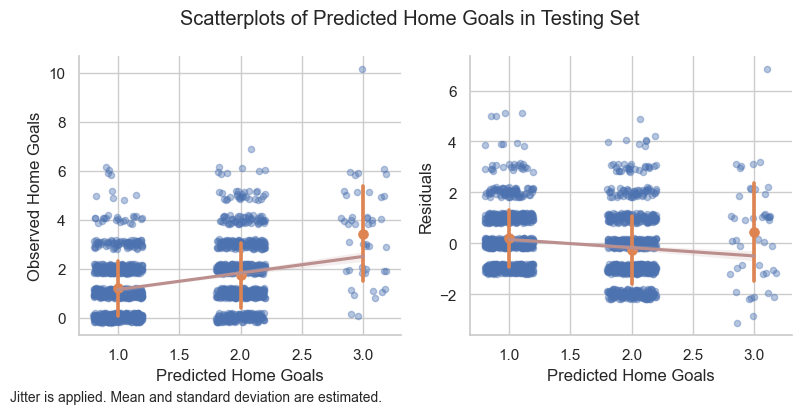

In [52]:
Y_test_home_goal_pred = discretize_and_above_zero(
    final_home_goal_reg.predict(X_test[features_home_goal_final])
)
fig = custom_model.print_regression_results(
    Y_test_home_goal, Y_test_home_goal_pred, y_name="Home Goals"
)
fig.suptitle("Scatterplots of Predicted Home Goals in Testing Set")
fig.text(0, 0, info_text, fontsize=10)
fig.set_figheight(4)
plt.show()

In [37]:
def discretize_and_above_zero(x):
    """Discretize and limit output to be above 0."""
    x_discrete = x.round()
    x_discrete[x_discrete < 0] = 0
    return x_discrete


def discrete_RMSE(y_true: pd.Series, y_pred_continuous: np.ndarray) -> float:
    """Calculate RMSE for discrete regression output."""
    y_pred_discrete = discretize_and_above_zero(y_pred_continuous)
    x = mean_squared_error(
        y_true=y_true,
        y_pred=y_pred_discrete,
        squared=False,
    )
    return x


def bayesian_ic(y_true: pd.Series, y_pred: np.ndarray, num_params: int) -> int:
    """Calculate Bayesian information criterion (BIC)."""
    mse = mean_squared_error(y_true, y_pred)
    n = len(y_true)
    bic = round(n * log(mse) + (num_params + 1) * log(n))
    return bic


from math import log

discrete_RMSE_scorer = make_scorer(discrete_RMSE, greater_is_better=False)
lin_reg = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler(), LinearRegression()
)
print(
    "Mean (standard deviation) of RMSE and BIC for linear regression model for"
    " home goal prediction:"
)
for i in range(10):
    feat = features_home_goal[: 10 - i]
    scores = cross_val_score(
        lin_reg,
        X_train[feat],
        Y_train_home_goal,
        cv=TimeSeriesSplit(n_splits=5),
        scoring=discrete_RMSE_scorer,
    )
    lin_reg.fit(X_train[feat], Y_train_home_goal)
    y_predict = lin_reg.predict(X_train[feat])
    y_predict = discretize_and_above_zero(y_predict)
    bic = bayesian_ic(Y_train_home_goal, y_predict, len(feat))
    print(
        f"{-scores.mean().round(3)} ({scores.std().round(3)}) and {bic} for"
        f" features {feat}"
    )

Mean (standard deviation) of RMSE and BIC for linear regression model for home goal prediction:
1.254 (0.018) and 4165 for features ['overall_rating_diff', 'overall_rating_home', 'season_scored_diff', 'season_points_max_diff', 'season_GD_home', 'win_prop_home', 'season_scored_avg_home', 'season_conceded_diff', 'loss_prop_home', 'overall_rating_away']
1.253 (0.018) and 4164 for features ['overall_rating_diff', 'overall_rating_home', 'season_scored_diff', 'season_points_max_diff', 'season_GD_home', 'win_prop_home', 'season_scored_avg_home', 'season_conceded_diff', 'loss_prop_home']
1.253 (0.021) and 4147 for features ['overall_rating_diff', 'overall_rating_home', 'season_scored_diff', 'season_points_max_diff', 'season_GD_home', 'win_prop_home', 'season_scored_avg_home', 'season_conceded_diff']
1.254 (0.018) and 4154 for features ['overall_rating_diff', 'overall_rating_home', 'season_scored_diff', 'season_points_max_diff', 'season_GD_home', 'win_prop_home', 'season_scored_avg_home']
1.255

The best RMSE is 1.254 goals achieved using three features defining difference in overall team rating, difference in scored goals during current season and overall home team rating. Bayesian information criterion (BIC) is also the lowest for this set of features.

In [38]:
features_home_goal_final = [
    "overall_rating_diff",
    "overall_rating_home",
    "season_scored_diff",
]
final_home_goal_reg = clone(lin_reg)
final_home_goal_reg.fit(X_train[features_home_goal_final], Y_train_home_goal)
custom_model.model_representation(final_home_goal_reg, type="regression")

IMPUTER


,overall_rating_diff,overall_rating_home,season_scored_diff
median,0.091,74.0,0.0


SCALER


,overall_rating_diff,overall_rating_home,season_scored_diff
Mean,0.084,74.533,-0.190
Scale,5.240,3.866,13.504


MODEL COEFFICIENTS


,overall_rating_diff,overall_rating_home,season_scored_diff,Intercept
0,0.249,0.156,0.123,1.549


The same RMSE value is achieved for training set. However, the developed model is only capable of explaining 6.8% of variance in scored home team goals. The model is incapable of predicting more that 3 goals and residuals have slightly wider standard deviation with more goals predicted. That is, heteroscedasticity is present and, therefore, model is unsatisfactory. 

RMSE = 1.252, R^2 = 0.068


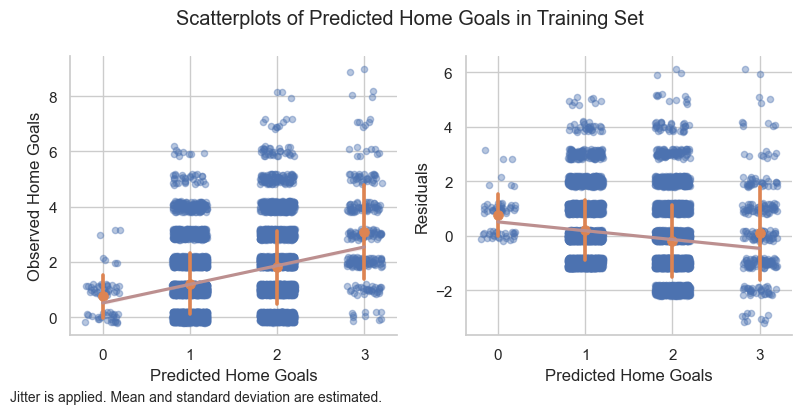

In [39]:
Y_train_home_goal_pred = discretize_and_above_zero(
    final_home_goal_reg.predict(X_train[features_home_goal_final])
)
fig = custom_model.print_regression_results(
    Y_train_home_goal, Y_train_home_goal_pred, y_name="Home Goals"
)
fig.suptitle("Scatterplots of Predicted Home Goals in Training Set")
info_text = "Jitter is applied. Mean and standard deviation are estimated."
fig.text(0, 0, info_text, fontsize=10)
fig.set_figheight(4)
plt.show()

Similar results are obtained on testing set. RMSE reaches 1.272 goals and 6.5% variance is explained by the model.

RMSE = 1.272, R^2 = 0.065


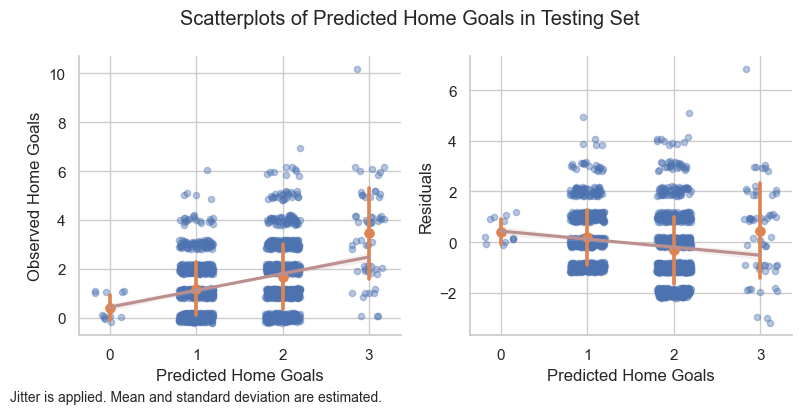

In [40]:
Y_test_home_goal_pred = discretize_and_above_zero(
    final_home_goal_reg.predict(X_test[features_home_goal_final])
)
fig = custom_model.print_regression_results(
    Y_test_home_goal, Y_test_home_goal_pred, y_name="Home Goals"
)
fig.suptitle("Scatterplots of Predicted Home Goals in Testing Set")
fig.text(0, 0, info_text, fontsize=10)
fig.set_figheight(4)
plt.show()

#### 7.2.1. <a id='toc7_2_1_'></a>Summary on Home Goal Prediction  [&#8593;](#toc0_)

Building a model to predict home team goals provides these insights:
1. Of the analyzed features, the ones defining difference in overall team rating, difference in scored goals during current season and overall home team rating are the most useful.
2. However, these features cannot capture tendencies in home team scoring, especially, considering higher number of goals.
3. The model exhibits heteroscedasticity, which could be the outcome of skewed regressor distributions or incorrectly specified model. 

### 7.3. <a id='toc7_3_'></a>Away Team Goal Prediction  [&#8593;](#toc0_)

Predicting away team goals is essentially the same task, just different features can be selected. However, here again, no features exhibit clear linear relationship with the number of goals scored by the away team.

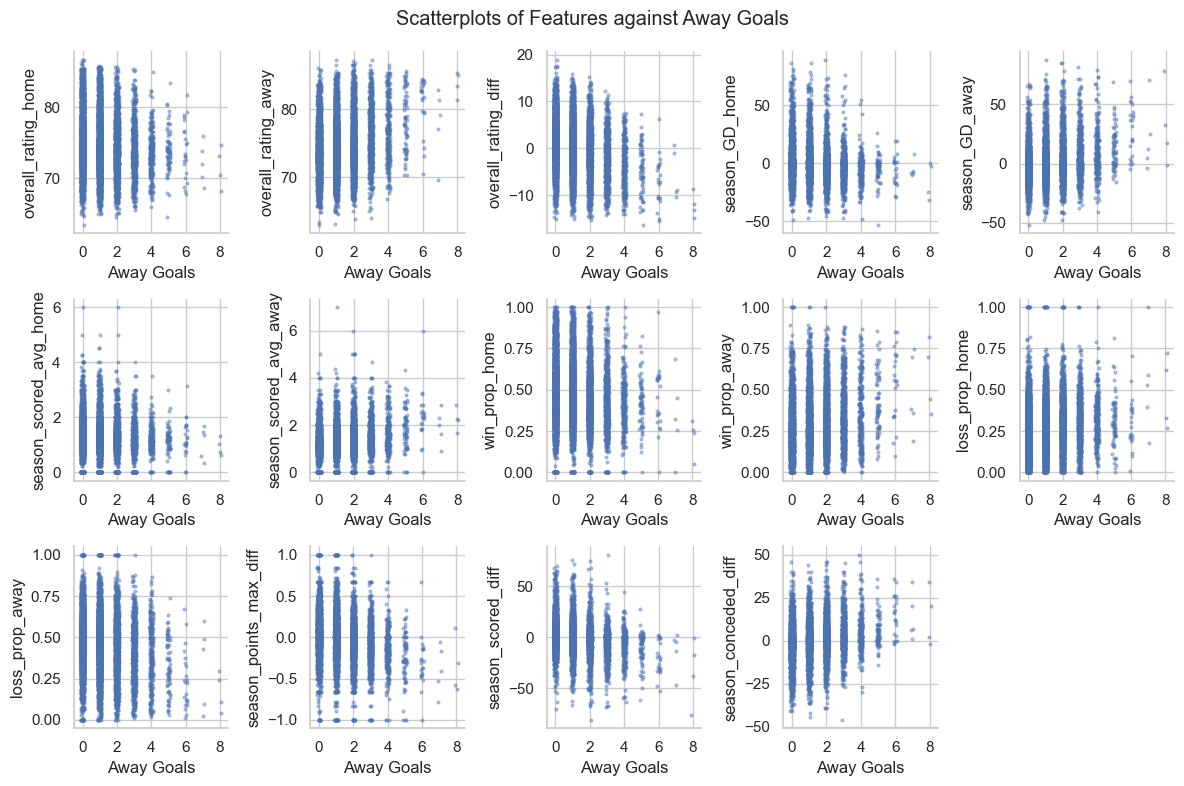

In [41]:
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.flatten()
for idx, col in enumerate(X_train.columns):
    sns.regplot(
        data=data_train,
        x="Away Goals",
        y=col,
        ax=axes[idx],
        x_jitter=0.1,
        scatter_kws={"s": 4, "alpha": 0.4},
        fit_reg=False,
    )
    axes[idx].set_xticks(range(0, 10, 2))
axes[14].axis("off")
fig.suptitle("Scatterplots of Features against Away Goals")
plt.show()

The distribution of away team goals resembles decaying exponential, i.e., higher number of goals is very rare.

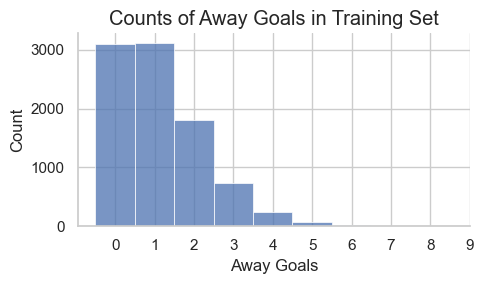

In [42]:
plt.figure(figsize=(5, 3))
ax = sns.histplot(data=data_train, x="Away Goals", discrete=True)
plt.xticks(range(10))
plt.title("Counts of Away Goals in Training Set")
plt.show()

Again, top ten features are selected to be used with away goal prediction based on linear regression tests returning F-statistic.

In [43]:
Y_train_away_goal = data_train["Away Goals"]
Y_test_away_goal = data_test["Away Goals"]
f, _ = f_regression(X_train_no_nans, Y_train_away_goal)
features_away_goal = (
    pd.Series(f, index=X_train.columns).nlargest(n=10).index.to_list()
)
features_away_goal

['overall_rating_diff',
 'overall_rating_away',
 'season_scored_diff',
 'season_points_max_diff',
 'season_GD_away',
 'win_prop_away',
 'season_scored_avg_away',
 'season_conceded_diff',
 'loss_prop_away',
 'season_GD_home']

The same cross validation procedure is used to compare different sets of features. 

In [44]:
print(
    "Mean (standard deviation) of RMSE and BIC for linear regression model for"
    " away goal prediction:"
)
for i in range(10):
    feat = features_away_goal[: 10 - i]
    scores = cross_val_score(
        lin_reg,
        X_train[feat],
        Y_train_away_goal,
        cv=TimeSeriesSplit(n_splits=5),
        scoring=discrete_RMSE_scorer,
    )
    lin_reg.fit(X_train[feat], Y_train_away_goal)
    y_predict = lin_reg.predict(X_train[feat])
    y_predict = discretize_and_above_zero(y_predict)
    bic = bayesian_ic(Y_train_away_goal, y_predict, len(feat))
    print(
        f"{-scores.mean().round(3)} ({scores.std().round(3)}) and {bic} for"
        f" features {feat}"
    )

Mean (standard deviation) of RMSE and BIC for linear regression model for away goal prediction:
1.115 (0.019) and 1968 for features ['overall_rating_diff', 'overall_rating_away', 'season_scored_diff', 'season_points_max_diff', 'season_GD_away', 'win_prop_away', 'season_scored_avg_away', 'season_conceded_diff', 'loss_prop_away', 'season_GD_home']
1.115 (0.019) and 1954 for features ['overall_rating_diff', 'overall_rating_away', 'season_scored_diff', 'season_points_max_diff', 'season_GD_away', 'win_prop_away', 'season_scored_avg_away', 'season_conceded_diff', 'loss_prop_away']
1.113 (0.02) and 1938 for features ['overall_rating_diff', 'overall_rating_away', 'season_scored_diff', 'season_points_max_diff', 'season_GD_away', 'win_prop_away', 'season_scored_avg_away', 'season_conceded_diff']
1.117 (0.022) and 1945 for features ['overall_rating_diff', 'overall_rating_away', 'season_scored_diff', 'season_points_max_diff', 'season_GD_away', 'win_prop_away', 'season_scored_avg_away']
1.115 (0.02

The set of features exhibiting not only the smallest mean RMSE (1.112 goals) but also the smallest Bayesian information criterion value is taken for final model definition. This set includes: difference in overall team rating, overall away team rating, difference in scored goals during current season, and difference in proportion of maximum available points obtained in current season.

In [45]:
features_away_goal_final = [
    "overall_rating_diff",
    "overall_rating_away",
    "season_scored_diff",
    "season_points_max_diff",
]
final_away_goal_reg = clone(lin_reg)
final_away_goal_reg.fit(X_train[features_away_goal_final], Y_train_away_goal)
custom_model.model_representation(final_away_goal_reg, type="regression")

IMPUTER


,overall_rating_diff,overall_rating_away,season_scored_diff,season_points_max_diff
median,0.091,73.909,0.0,0.0


SCALER


,overall_rating_diff,overall_rating_away,season_scored_diff,season_points_max_diff
Mean,0.084,74.449,-0.190,-0.009
Scale,5.240,3.901,13.504,0.260


MODEL COEFFICIENTS


,overall_rating_diff,overall_rating_away,season_scored_diff,season_points_max_diff,Intercept
0,-0.164,0.107,-0.082,-0.036,1.148


RMSE value of 1.107 goals is achieved for training set. However, the developed model is only capable of explaining 5.6% of variance in scored away team goals. The model is incapable of predicting more that 2 goals and residuals have slightly wider standard deviation with more goals predicted. Again, heteroscedasticity is present. 

RMSE = 1.107, R^2 = 0.056


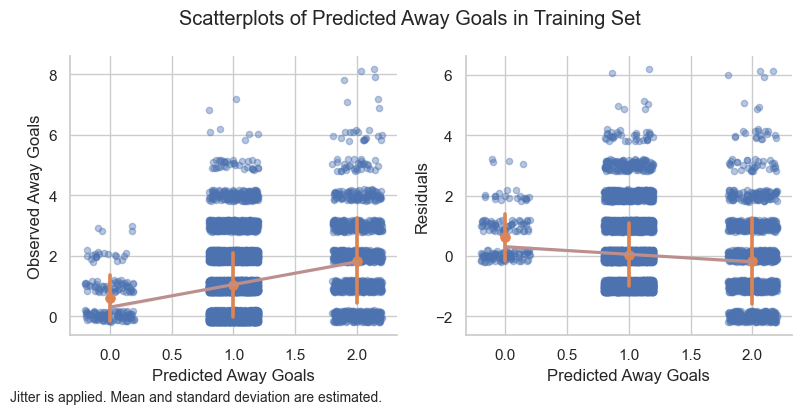

In [46]:
Y_train_away_goal_pred = discretize_and_above_zero(
    final_away_goal_reg.predict(X_train[features_away_goal_final])
)
fig = custom_model.print_regression_results(
    Y_train_away_goal, Y_train_away_goal_pred, y_name="Away Goals"
)
fig.suptitle("Scatterplots of Predicted Away Goals in Training Set")
fig.text(0, 0, info_text, fontsize=10)
fig.set_figheight(4)
plt.show()

On testing set, RMSE reaches 1.097 goals and 6.0% variance is explained by the model.

RMSE = 1.097, R^2 = 0.06


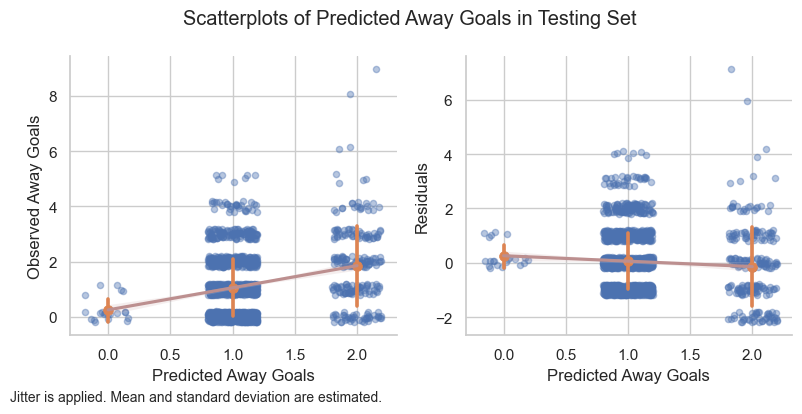

In [47]:
Y_test_away_goal_pred = discretize_and_above_zero(
    final_away_goal_reg.predict(X_test[features_away_goal_final])
)
fig = custom_model.print_regression_results(
    Y_test_away_goal, Y_test_away_goal_pred, y_name="Away Goals"
)
fig.suptitle("Scatterplots of Predicted Away Goals in Testing Set")
fig.text(0, 0, info_text, fontsize=10)
fig.set_figheight(4)
plt.show()

#### 7.3.1. <a id='toc7_3_1_'></a>Summary on Away Goal Prediction  [&#8593;](#toc0_)

Building a model to predict away team goals provides these insights:
1. Of the analyzed features, the ones defining difference in overall team rating, overall away team rating, difference in scored goals during current season, and difference in proportion of maximum available points obtained in current season are the most useful.
2. As with home goal prediction, these features cannot capture tendencies in away team scoring, especially, considering higher number of goals.
3. Possibly, another model should be specified to deal with heteroscedasticity. 

## 8. <a id='toc8_'></a>Recommendations  [&#8593;](#toc0_)

Based on the analysis of the provided European football dataset, the following recommendations could be useful for the betting company willing to enter the market:
1. Anticipate more goals per match (closer to 3) in the Netherlands or Switzerland leagues. However, in France and Poland leagues, anticipate fewer goals (closer to 2). There are certain players who score more goals; therefore, their participation in the match could be useful in predicting the number of goals.
2. Home advantage is a prevailing phenomenon, with home teams tending to score more goals than away teams. However, the effect of home advantage can vary from season to season and seemed to decrease in the last two seasons analyzed. Moreover, the impact of home advantage is not consistent across leagues, being more pronounced in Spain and the Netherlands and less so in Portugal and Scotland.
3. Player formations can influence the proportions of won, drawn, and lost matches. Teams using the 5-3-2 formation tend to have fewer wins but an increased proportion of draws.
4. Precisely predicting the outcome of a match is a challenging task. Betting companies currently in the business achieve a 53% precision, but simply predicting a home team win already yields 44-46% precision. The developed model achieved a 48% precision for the top five leagues. To increase the precision score, additional features may be required, possibly involving non-linear models.
5. Predicting the exact number of goals scored by each team is an even more complicated task, especially for higher goal numbers. Additional features and more sophisticated models may be necessary, and it is possible that only a probability of a certain number of goals can be estimated.

## 9. <a id='toc9_'></a>Suggestions for Improvements  [&#8593;](#toc0_)

The analysis of this extensive European football dataset can be improved in multiple ways:
* The home advantage effect can be analyzed for specific teams. Additionally, potential confounding factors (e.g., weather conditions) that might influence the results could be considered.
* Since there are betting odds from other companies provided, league predictability can be estimated to identify leagues where predicting match outcomes is easier.
* League-specific models can be built to improve match result predictions.
* The currently developed features are not capable of capturing relevant information for predicting match outcomes or scored goals. Therefore, error analysis could be employed to engineer better features, which may address the currently present heteroskedasticity.
* Non-linear models can be experimented with to capture potentially existing non-linear relationships.
* Predicting scored goals could be approached as an ordinal classification task, where a higher number of goals is treated as a single class.

## 10. <a id='toc10_'></a>Data for Looker Studio Dashboard [&#8593;](#toc0_)

Dataframe of scored goals is saved to `.csv` file.

In [48]:
goals_df.to_csv("./data/goals.csv", index=False)

Looker Studio dashboard of top 5 football leagues scoring can be found at this [link](https://lookerstudio.google.com/reporting/4ed05526-6afe-4429-9d59-f8e4f5558c2a).